<img align="left" width="30%" style="padding-right:10px;" src="../Images/Ccom.png">

___
# Computational Problem Set - Being a VGNSS Receiver

## Step 5: Construction of Observations, Creating the Initial Estimate 
### Our entry to the Real World...

## Semme J. Dijkstra, David E. Wells

<a href="https://teams.microsoft.com/l/channel/19%3afd7ef9823b064892bc126bc40f2b4710%40thread.tacv2/VGNSS?groupId=ed82d769-1aaa-4613-9de0-2dd04127f30a&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="../Images/help.png"  title="Ask questions on Teams" align="right" width="10%" alt="Piazza.com\"></a><br><br> 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
Reading SP3 file: ../mydata/igs13381.sp3
Reading SP3 file: ../mydata/igl13381.sp3
Reading rinex nav file: ../mydata/brdc2410.05n
a:      6378137.000
b:      6356752.314
f:  0.0033528106718
e2: 0.0066943800043
N:     6383561.9968
xyz = 
	      36572.327
	   -5514234.862
	    3194349.181
n_gps: 29

Dxyz_gps = 
	  -14810463.942    -9214095.559    13455967.472
	   13541201.761    26996353.844   -11445216.142
	  -20837451.276    -5980879.278   -15470790.135
	    4277463.860    31010341.499     2010886.176
	   19866345.462    -2252512.679    12298837.345
	   19536837.223    -3005783.142   -18858064.521
	    1056165.459    2

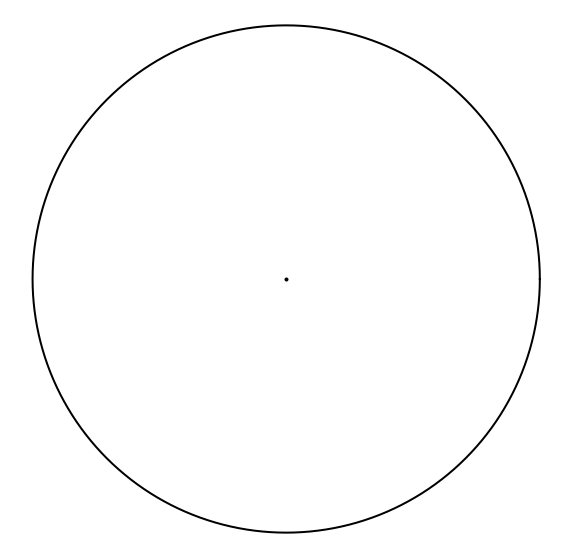

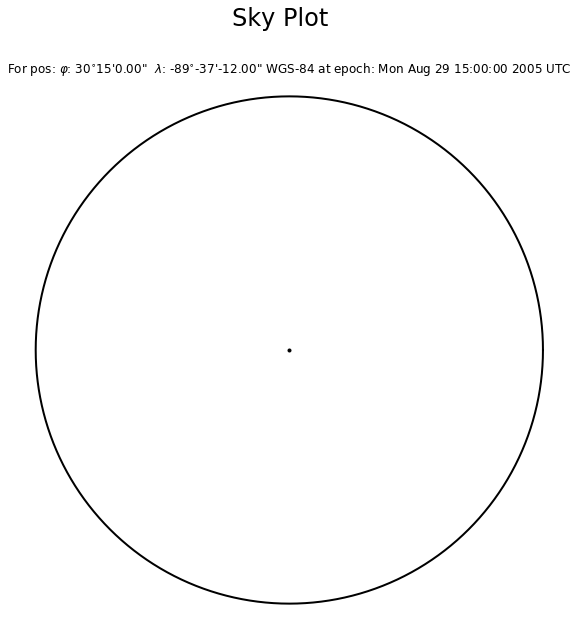

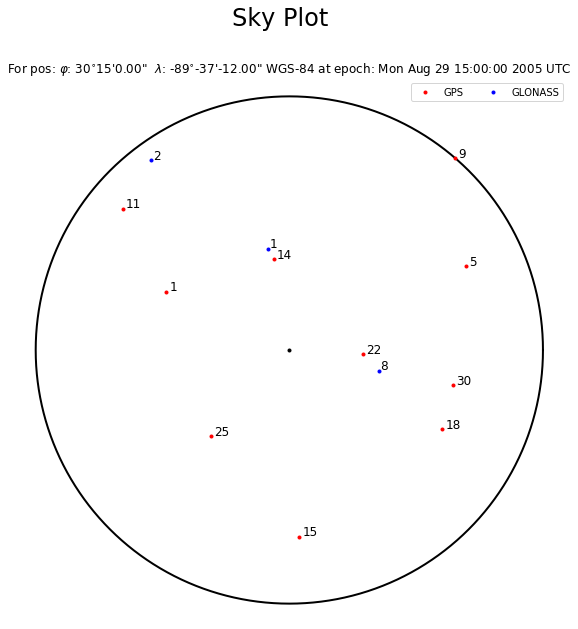

In [30]:
%load_ext autoreload
%autoreload 2


import sys
import os
import numpy as np

from numpy import cos,pi,sin,pi,arccos, tan, arctan, arctan2, sqrt
from numpy.linalg import inv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path
from IPython.display import HTML
vgnss_path=Path('../') # Get the path to the folder containing the mycode folder

print(vgnss_path.resolve())
sys.path.append(str(vgnss_path.resolve())) # add the folder to the list of paths 
from mycode.gnss import GNSS
from mycode.sp3 import SP3
# Start by running your previous steps - suppress the output by setting verbose to False

verbose = True
%run VGNSS_4.ipynb
plt.show()



from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

# from mycode.lsq import LSQ
# from mycode.ephemeris import Ephemeris

<div hidden>

$\usepackage{amsmath,amssymb}$

$\DeclareRobustCommand{\bbone}{\text{\usefont{U}{bbold}{m}{n}1}}$

$\DeclareMathOperator{\EX}{\mathbb{E}}% expected value$

$\DeclareMathOperator{\res}{\vec{r}}$
    
$\newcommand{\ex}[1]{\mathbb{E}\{#1\}}$
    
$\newcommand{\dev}[1]{\mathbb{E}\{#1 - \mathbb{E}\{#1\}\}}$
    
$\newcommand{\cov}[1]{\mathbb{E}\{(#1 - \mathbb{E}\{#1\})(#1 - \mathbb{E}\{#1\})^T\}}$
</div>

___

## 5.0 Construct Pseudoranges (Add Uncertainty)

In steps `4.3.0` and `4.3.1` we calculated the true ranges from our receiver to the GPS and GLONASS satellites, these are the ***observables***. However, if we knew these distances to begin with we would know exactly where we are. In real life we make ***observations*** of the baselines between our locations and the reference points which we are measuring from or to. In surveying we tend to measure the length (range) and/or direction (angles) of the baseline. 

If we only measure the lengths the process of determining  coordinates from the observation is referred to as **trilateration**. If we measure directions (with or without distance) the process is referred to as **triangulation**. Historically triangulation was more common for survey projects due to the fact that it was far easier to measure angles than distances. Angles could be observed using a scope (with instruments such as theodolites and sextants) with a high degree of precision. Distances had to be measured physically e.g., with a tape measure, a cumbersome and error-prone method of doing observations. The developments of radio positioning in the early 20th century lead to more common use of trilateration for lower accuracy applications as the time of flight of signals between beacons could be measured. A rapid transition to trilateration becoming dominant happened in the eighties and early nineties with the advent of highly accurate two-way electronic distance measurement and the launching of the GPS system. Currently trilateration is the vastly more common approach as GNSS receivers have become our primary instruments.

At this point it is important to note that a distinction can be drawn between direct measurements of distance (**ranging**) such as with tape measures, and indirect measurements (**pseudo ranging**) obtained with remote sensing techniques in which we observe the time of flight of a signal along a baseline. Radar, lidar, and sonar are examples of technologies that can be used to get these indirect time of flight measures. Distance is then obtained by using a model of the propagation speed (**celerity** c) of the signal along its path. The quality of the observation is then not only a function of the quality of the instrument clock used, but also a function of the quality of the propagation model of the medium the signals traverse. The term **pseudorange** is then used to remind us that we are using a time observation proxy observed distance.

There are other sources of error as well: in this step we will go through all the error sources as defined in step 1 to create ***synthetic*** observations i.e., observations that in a somewhat realistic manner mimic the observations that we would acquire with an actual GNSS receiver at the time and place defined in step 1.




___
## 5.1 Replace Blunder Vehicle if Necesarry

For the educational purposes of this assignment it is important that we do have an observation with a gross error: in this step we ensure that this is the case. In step 1.3.3 We defined a blunder vehicle in the list `bv` i.e., a satellite from which the observed pseudorange is grossly incorrect. At the time of the definition you probably did not know whether the satellite associated to the PRN was visible from your chosen location and time. In step 4 We were able to identify which PRNs are associated to satellite vehicles located above the horizon by transforming the satellite vehicle (sv) ephemeris data to a topocentric NEU reference frame centered on the location of the receiver. Thus, we can easily determine whether our `bv` is visible or not. 

If `bv` is not visible re-assign its PRN to the first visible satellite in the same constellation i.e., the sv contained in the first visible row of the matrix `rho_az_elev_gps` or `rho_az_elev_gln`.

In [31]:
# 5.1 re-assign the satellite identified by the list bv if necesarry

if bv[0] == 1:
    if any(p_az_elev_gps[visible_gps, 0] == bv[1]):
        if verbose:
            print('GPS vehicle '+str(bv[1]) + ' is visible')
    else:
        if verbose:
            print('GPS PRN '+str(bv[1]) + ' is not visible; re-assigning bv to GPS PRN '
                  + str(int(p_az_elev_gps[visible_gps, 0][0])))
        bv = [1, int(p_az_elev_gps[visible_gps, 0][0])]
        
elif bv[0] == 2:
    if any(p_az_elev_gln[..., ...] == ...):
        if verbose:
            print('GLONASS vehicle '+str(bv[1]) + ' is visible')
    else:
        if verbose:
            print('GLONASS PRN '+str(bv[1]) + ' is not visible; re-assigning bv to GPS PRN '
                  + str(int([visible_gln, 0][0])))
        bv = [1, int(...)]

GPS PRN 2 is not visible; re-assigning bv to GPS PRN 1


Worked Example:

    GPS PRN 2 is not visible; re-assigning bv to GPS PRN 1

___
## 5.2 Calculate Total Uncertainty to be Applied to each GPS Satellite Range

To select an appropriate uncertainty model for GNSS measurements.

As we have seen GNSS receivers do not measure true distances, but rather Pseudoranges. The GNSS code observation equation includes terms for:

    1	Time synchronization bias (solved for by the method of the least squares)
    2	Ionosphere group delay (may be determined from the observations if the receiver is dual frequency)
    3	Troposphere refraction (use theoretical models based on surface weather)
    4	Multi-path (special antennas, and multiple tracking loops can help)
    5	Receiver noise (narrow correlator receivers reduce this by a factor of 10 or more)
    6	Blunders or accidental misreadings.  
    
Blunders can be caused by many factors, and are essentially failures of the GNSS measurement process.  Some are small and undetectable; others are so large they can be identified as **outliers** or **fliers** in comparison with the other measurements.

If we ignored these facts, and attempted to use the "perfect" observations (geometric distances) from step 4 then the least squares fix will result in zero-valued residuals, and an uncertainty region of zero magnitude in every dimension - clearly very unrealistic.

The purpose of this assignment is NOT to develop a sophisticated error model, but to add some kind of errors to the data, so that the residuals calculated in our Least Squares Adjustments will be non-zero and behave in a somewhat realistic fashion.  Thus for this exercise, we will use a very simple error model.

Let’s be clear:  what we are doing is playing God: we are adding errors to our measurements as a proxy for what Mother Nature does in real life.

What we are doing is then to compute virtual GNSS uncertainty values to be applied in Step 5.0.2.

The uncertainty model is given by the equation is:

$$\text{Total Uncertainty} = \text{Tropospheric delay uncertainty} + \text{Random uncertainty representing receiver tracking loop noise} + \text{Time synchronization bias}$$

In addition, only satellite `bv` will have a blunder added to its total uncertainty.

In this step we will first create a column vector `rnd_gps` consisting of the first `n_gps` random numbers contained in the list `rnd`. Then we will assign the number of visible satellites to the variable `n_gps_vis`. Finally, we will generate the `n_gps` x 7 matrix `error_gps` holding all the error components for each of the visible GPS satellites. The columns of `error_gps` will represent  the PRN, the elevation angle [rad], the troposheric delay [m], the random noise [m], the clock bias[m], the blunder[m] and, the total uncertainty[m].

$$\text{Tropo Model} = \begin{cases}
    \dfrac{k}{\sin(\sqrt{\theta^2 + C^2})}, \{\theta|0 \leq \theta \leq 90,\theta\in\mathbb{R}\} \\ \\ 0, \text{everywhere else}
\end{cases}
$$

In [32]:
## 5.2 Calculate Total Uncertainty to be Applied to each GPS Satellite Range
# Assing the first n_gps random numbers to the column vector rnd_gps
rnd_gps=np.array(rnd[0:n_gps]).reshape(n_gps,1)

# Determine the number of visible GPS satellites
n_gps_vis = sum(visible_gps)

# Allocate memory
error_gps = np.zeros((n_gps_vis,7))

# Set the PRNs of the GPS satellites in the first column
error_gps[:,0:1]=p_az_elev_gps[visible_gps,0:1]

# Add the elevations in the 2nd column
error_gps[:,1:2]=p_az_elev_gps[visible_gps,3:4]

# Add the tropospheric error from the model defined in step 1.3.2 in the 3d column
if verbose:
    print('Tropo delay model: %4.2f/sin(sqrt(elev^2+%4.2f^2))'%(k,C*180/pi))
error_gps[:,2:3]=k/sin(sqrt(error_gps[:,1:2]**2+C**2))

# Add the random noise in the 4th column
error_gps[:,3:4]=rnd_gps[visible_gps]

# Add the clockbias (mapped to meters) in the 5th column
error_gps[:,4:5]=rx_dt*c

# If the blunder vehicle is part of the GPS constellation add the blunder to the vehicle identifies by bv

if bv[0]==1:
    error_gps[error_gps[:,0]==bv[1],5]=blunder
    
# Finally determine the total uncertainty
error_gps[:,-1]=np.sum(error_gps[:,2:],1)


if verbose:
    print('rnd_gps = ')
    for r in rnd_gps:
        print('\t%15.3f'%r)
    print('\nn_gps_vis = %d\n'%n_gps_vis)
    print('error_gps = ')
    print('\t  PRN    elev  Tr. Delay Rnd Noise   Clock Bias  Blunder   Tot. Uncertainty')
    for i in range(n_gps_vis):
        print('\t%5d %7.3f %10.3f %9.3f %12.3f %8.3f   %16.3f'% \
            (error_gps[i,0],error_gps[i,1],error_gps[i,2],error_gps[i,3], \
             error_gps[i,4],error_gps[i,5],error_gps[i,6]))

Tropo delay model: 2.31/sin(sqrt(elev^2+2.50^2))
rnd_gps = 
	          1.728
	         -0.805
	          0.683
	          2.402
	         -1.062
	          0.499
	          1.848
	         -2.193
	         -1.838
	         -0.146
	         -1.439
	          1.003
	          2.381
	         -1.607
	          0.900
	          1.803
	          2.760
	          1.692
	          1.351
	          1.315
	         -2.802
	          0.527
	         -2.984
	          0.228
	          0.942
	         -0.520
	          2.122
	          2.472
	          1.306

n_gps_vis = 10

error_gps = 
	  PRN    elev  Tr. Delay Rnd Noise   Clock Bias  Blunder   Tot. Uncertainty
	    1   0.728      3.468     1.728     1000.000 2000.000           3005.196
	    5   0.359      6.522    -1.062     1000.000    0.000           1005.460
	    9   0.002     52.891    -1.838     1000.000    0.000           1051.053
	   11   0.219     10.436    -1.439     1000.000    0.000           1008.997
	   14   1.000      2.744     2.

Worked Example:

    Tropo delay model: 2.31/sin(sqrt(elev^2+2.50^2))

    rnd_gps = 
	          1.728
	         -0.805
	          0.683
	          2.402
	         -1.062
	          0.499
	          1.848
	         -2.193
	         -1.838
	         -0.146
	         -1.439
	          1.003
	          2.381
	         -1.607
	          0.900
	          1.803
	          2.760
	          1.692
	          1.351
	          1.315
	         -2.802
	          0.527
	         -2.984
	          0.228
	          0.942
	         -0.520
	          2.122
	          2.472
	          1.306

    n_gps_vis = 10

    error_gps = 
	  PRN    elev  Tr. Delay Rnd Noise   Clock Bias Blunder   Tot. Uncertainty
	    1   0.728      3.468     1.728     1000.000 2000.000           3005.196
	    5   0.359      6.522    -1.062     1000.000    0.000           1005.460
	    9   0.002     52.891    -1.838     1000.000    0.000           1051.053
	   11   0.219     10.436    -1.439     1000.000    0.000           1008.997
	   14   1.000      2.744     2.381     1000.000    0.000           1005.126
	   15   0.412      5.745    -1.607     1000.000    0.000           1004.138
	   18   0.506      4.751     1.803     1000.000    0.000           1006.554
	   22   1.114      2.573     1.315     1000.000    0.000           1003.888
	   25   0.851      3.070    -2.984     1000.000    0.000           1000.086
	   30   0.532      4.537     2.472     1000.000    0.000           1007.009

___
## 5.3 Calculate Total Uncertainty to be Applied to each GLONASS Satellite Range

Similar to step 5.0.1 we will first create a column vector consisting of the last `n_gln` random numbers contained in the list `rnd`. We will then assign the number of visible satellites to the variable `n_gln_vis`, finally we will generate the `n_gln` x 7 matrix `error_gln` holding all the error components for each of the visible GLONASS satellites. The columns of error_gln will represent the PRN, the elevation angle [rad], the troposheric delay [m], the random noise [m], the clock bias[m], the blunder[m] and, the total uncertainty[m].


In [39]:
# 5.3 Calculate Total Uncertainty to be Applied to each GLONASS Satellite Range
# Assing the next n_gln random numbers to the column vector rnd_gln
rnd_gln = np.array(rnd[n_gps:]). ...

# Determine the number of visible GPS satellites
n_gln_vis = ...

# Allocate memory for matrix error_gln
error_gln = np.zeros(...)

# Set the PRNs of the GLONASS satellites in the first column
error_gln[:, 0:1] = ...

# Add the elevations in the 2nd column
error_gln[:, 1:2] = ...

# Add the tropospheric error from the model defined in step 1.3.2 in the 3d column
if verbose:
    print('Tropo delay model: %4.2f/sin(sqrt(elev^2+%4.2f^2))' % (k, C*180/pi))
error_gln[:, 2:3] = ...

# Add the random noise in the 4th column
error_gln[:, 3:4] = ...

# Add the clockbias (mapped to meters) in the 5th column
error_gln[:, 4:5] = ...

# If the blunder vehicle is part of the GLONASS constellation add the blunder to the vehicle identifies by bv
if bv[0] == 2:
    error_gln[...], 5] = ...

# Finally determine the total uncertainty
error_gln[:, -1] = ...


if verbose:
    print('rnd_gln = ')
    for r in rnd_gln:
        print('\t%15.3f' % r)
    print('\nn_gln_vis = %d\n' % n_gln_vis)
    print('error_gln = ')
    print('\t  PRN    elev  Tr. Delay Rnd Noise   Clock Bias  Blunder   Tot. Uncertainty')
    for i in range(n_gln_vis):
        print('\t%5d %7.3f %10.3f %9.3f %12.3f %8.3f   %16.3f' %
              (error_gln[i, 0], error_gln[i, 1], error_gln[i, 2], error_gln[i, 3],
               error_gln[i, 4], error_gln[i, 5], error_gln[i, 6]))

Tropo delay model: 2.31/sin(sqrt(elev^2+2.50^2))
rnd_gln = 
	          2.160
	          2.538
	         -2.426
	         -1.807
	         -2.776
	          2.433
	         -0.752
	          2.455
	         -1.398
	         -1.285
	         -1.756
	          2.404

n_gln_vis = 3

error_gln = 
	  PRN    elev  Tr. Delay Rnd Noise   Clock Bias  Blunder   Tot. Uncertainty
	    1   0.928      2.883     2.160     1000.000    0.000           1005.043
	    2   0.117     18.526     2.538     1000.000    0.000           1021.064
	    8   1.002      2.739     2.433     1000.000    0.000           1005.172


Worked Example:

    Tropo delay model: 2.31/sin(sqrt(elev^2+2.50^2))
    rnd_gln = 
	          2.160
	          2.538
	         -2.426
	         -1.807
	         -2.776
	          2.433
	         -0.752
	          2.455
	         -1.398
	         -1.285
	         -1.756
	          2.404

    n_gln_vis = 3

    error_gln = 
	  PRN    elev  Tr. Delay Rnd Noise   Clock Bias  Blunder   Tot. Uncertainty
	    1   0.928      2.883     2.160     1000.000    0.000           1005.043
	    2   0.117     18.526     2.538     1000.000    0.000           1021.064
	    8   1.002      2.739     2.433     1000.000    0.000           1005.172

___
## 5.4 Calculate The GPS Pseudoranges

Apply the total uncertainty values from steps 5.0.1 and 5.0.2 to obtain realistic (but artificial) simulated GNSS receiver pseudoranges.

Compute the pseudoranges using:

$$\text{pseudorange} = \text{geometric (perfect) range} + \text{total uncertainty} $$

Assign the pseudoranges to the `n_gps_vis` x 2 matrix `obs_gps`. The first column will hold the PRN code for each GPS satellite vehicle, the second column will hold the `measured range`.

In [42]:
# 5.4 Calculate the GPS Pseudoranges

# Allocate memory
obs_gps = np.zeros((n_gps_vis, 2))

obs_gps[:, 0] = error_gps[:, 0]
obs_gps[:, 1:2] = rho_gps[visible_gps]+error_gps[:, 6:7]

if verbose:
    print('Observed pseudoranges: ')
    for i in range(n_gps_vis):
        print('%15.3f to GPS PRN %2d ' % (obs_gps[i, 1], obs_gps[i, 0]))

Observed pseudoranges: 
   22032813.633 to GPS PRN  1 
   23474541.526 to GPS PRN  5 
   25444682.772 to GPS PRN  9 
   24469069.082 to GPS PRN 11 
   21031486.016 to GPS PRN 14 
   23243891.073 to GPS PRN 15 
   22712828.074 to GPS PRN 18 
   20762936.197 to GPS PRN 22 
   21418246.029 to GPS PRN 25 
   22628290.792 to GPS PRN 30 


Worked Example:

    Observed pseudoranges: 
       22032813.633 to GPS PRN  1 
       23474541.526 to GPS PRN  5 
       25444682.772 to GPS PRN  9 
       24469069.082 to GPS PRN 11 
       21031486.016 to GPS PRN 14 
       23243891.073 to GPS PRN 15 
       22712828.074 to GPS PRN 18 
       20762936.197 to GPS PRN 22 
       21418246.029 to GPS PRN 25 
       22628290.792 to GPS PRN 30 


___
## 5.5 Calculate The GLONASS Pseudoranges

Similar to step 5.03 assign the GLONASS pseudoranges to the `n_gln_vis` x 2 matrix `obs_gln`. The first column will hold the PRN code for each GLONASS satellite vehicle, the second column will hold the `measured range`.

In [44]:
# 5.5 Calculate the GLONASS Pseudoranges

# Allocate memory
obs_gln = np.zeros((n_gln_vis, 2))

obs_gln[:, 0] = ...
obs_gln[:, 1:2] = rho_gln[...]+error_gln...

if verbose:
    print('Observed pseudoranges: ')
    for i in range(n_gln_vis):
        print('%15.3f to GLONASS PRN %2d ' % (obs_gln[i, 1], obs_gln[i, 0]))

Observed pseudoranges: 
   20101960.993 to GLONASS PRN  1 
   23878065.140 to GLONASS PRN  2 
   19892960.260 to GLONASS PRN  8 


Worked Example:

    Observed pseudoranges: 
       20101960.993 to GLONASS PRN  1 
       23878065.140 to GLONASS PRN  2 
       19892960.260 to GLONASS PRN  8 


___
## 5.6 GPS A-Priori Measurement Uncertainty

For this positioning problem we will use the parametric least squares methods to estimate our unknown position at the time of interest. In navigation parlance determining a positions at epochs is known as creating *fixes*. The least squares fix algorithm will not know the details of what we have conspired to do in this step; we are adding uncertainties ourselves, simulating the natural measurement process.  However, it is helpful, and usual, to provide to the least squares algorithm some kind of guess at what the general magnitude of the errors will be.  This is most often a single number that represents the average uncertainty in real measurements similar to those we have artificially manufactured.

What should go into the calculation of this number?

Not the clock bias, since we don’t consider that a measurement uncertainty – it is an unknown parameter to be estimated in the least squares process.

Not the blunder – that is by definition something unexpected and unpredictable. Also, we expect to remove its influence from the estimate in post processing.

That leaves us with the random uncertainty and the systematic (tropospheric) uncertainty.

First, a few words about the wisdom of including the tropospheric uncertainty:  in precise positioning applications of GNSS, a couple of strategies are used to account for tropospheric errors.  In the first strategy, a model is used to predict the tropospheric error, and account for it in the least squares estimation process (often one of the models discussed in Step 1.3.2).  In the second strategy, the uncertainty assumed for each GNSS pseudorange measurement is dependent upon its elevation angle, so that measurements near the horizon have less influence on the position fix than those at higher elevations.  Both these strategies are too complex for us to use here, so we will use the simplest approach, and make the *false* assumption that tropospheric errors are random in nature, rather than systematic.

So, a reasonable value for us to use, to characterize the estimated overall measurement uncertainty going into the least squares process (the a-priori uncertainty), is the average measurement variance.

Compute the measurement variance for each of the visible satellites, including only the random and tropospheric components, as:

$$\sigma_i^2= \text{variance for satellite i} = \text{random error}^2 + \text{tropo error}^2$$

Then take the average value for all the individual satellite variances:

$$\hat{\sigma_0^2}=\frac{\sum_{i}\sigma_i^2}{n}$$

In the code cell below generate the `n_gps_vis` x 1 array `var_gps` of the measurement variances for each visible gps satellite, and the scalar variable `var_a_priori_gps` holding the average variance.


In [36]:
# 5.6 GPS A-Priori Measurement Uncertainty

# Allocate memory
var_gps = np.zeros((n_gps_vis, 1))
# Determine the variance of each of the observations
var_gps = error_gps[:, 2:3]**2+error_gps[:, 3:4]**2
# Determine the average variance and use this as the estimated a-priori msmt uncertainty
var_a_priori_gps = sum(var_gps)/n_gps_vis

if verbose:
    print('var_gps = ')
    for i in range(n_gps_vis):
        print('%12.3f' % var_gps[i])

    print('\nvar_a_priori_gps  = %12.3f' % var_a_priori_gps)

var_gps = 
      15.013
      43.671
    2800.876
     110.975
      13.202
      35.582
      25.821
       8.350
      18.330
      26.693

var_a_priori_gps  =      309.851


Worked Example:
    
    var_gps = 
      15.013
      43.671
    2800.876
     110.975
      13.202
      35.582
      25.821
       8.350
      18.330
      26.693

    var_a_priori_gps  =      309.851


___
## 5.7 GLONASS A-Priori Measurement Uncertainty
	 
In the code cell below generate the `n_gln_vis` x 1 array `var_gln` of the measurement variances for each visible GLONASS satellite, and the scalar variable `var_a_priori_gln` holding the average variance.


In [37]:
# 5.7 GLONASS A-Priori Measurement Uncertainty

# Allocate memory
var_gln = np.zeros(...)

# Determine the variance of each of the observations
var_gln = ...

# Determine the average variance and use this as the estimated a-priori msmt uncertainty
var_a_priori_gln = ...

if verbose:
    print('var_gln = ')
    for i in range(n_gln_vis):
        print('%12.3f' % var_gln[i])

    print('\nvar_a_priori_gln  = %12.3f' % var_a_priori_gln)

var_gln = 
      12.979
     349.654
      13.422

var_a_priori_gln  =      125.352


Worked Example: 
    
    var_gln = 
      12.979
     349.654
      13.422

    var_a_priori_gln  =      125.352

___
## 5.8 Combined Constellation Measurement Uncertainty
	 
In our parametric method of the least squares solution we will combine the GPS and GLONASS observations. As we have seen the model leading to the a-priori uncertainty estimate is independent of the constellation that we use i.e., we may combine the estimates for each to get a better overall estimate. In this combination we should weight estimates by the number of estimations that contributed to them:

$$\hat{\sigma_0^2}=\dfrac{\hat\sigma_{0,\text{GPS}}^2\cdot n_{\text{GPS}}+\hat\sigma_{0,\text{GLONASS}}^2\cdot n_{\text{GLONASS}}}{n_{\text{GPS}}+n_{\text{GLONASS}}}$$

where:

$\hat\sigma_{0,GPS}^2\text{          }$        : a-priori variance factor for visible GPS svs<br>
$\hat\sigma_{0,GLONASS}^2\text{          }$: a-priori variance factor for visible GLONASS svs<br>
$n_{\text{GPS}}\text{          }$           : Number of visible GPS satellites<br>
$n_{\text{GLONASS}}\text{          }$       : Number of visible GLONASS satellites

In the code cell below combine the a-priori variance estimates of both constellations and assign the value to the scalar `var_a_priori`


In [28]:
# 5.8 A-priori measurement uncertainty for the combined constellations

var_a_priori = (...*n_gps_vis+var_a_priori_gln *
                ...)/(...+...)

if verbose:
    print('var_a_priori = '+str(var_a_priori))

var_a_priori = [267.27445058]


Worked Example: 
    
    var_a_priori = [267.27445058]

___
## 5.9 Estimate of Initial Unknown Parameter Values

We have reached a milestone in the set of VGNSS assignments. This step is the last one in which we generate synthetic data to mimic the types of observations a GNSS receiver will make. In reality a receiver does not know anything about these steps. A receiver makes the pseudorange observations (which may be done through code observations and/or phase observations) and uses these data, together with ephemeris data, a-priori uncertainty estimate and potentially some propagation models to resolve the position fix. Since the observations place us on spheres centered on the satellite vehicles the problem is non-linear i.e., we will need to use the non-linear version of the parametric method of the least squares (if we use the method of the least squares, which is by far the most common methodology). Thus we need an initial estimate of our position that we will refine through adjustments to the estimate. For our initial estimate we will use the true ECEF receiver position `xyz` found in step 4.1.2  and the offsets defined in as`bias` in step 1.3.4 to determine our initial estimate `xyzt_0` as a 4x1 array.

$$\hat{X}_0= \begin{pmatrix}X \\ Y \\ Z \\ \_ \\ \Delta t \end{pmatrix}+\vec{\text{bias}}$$



In [45]:
# 5.9 Estimate of Initial Unknown Parameter Values

# Allocate memory
xyzt_0 = np.zeros((4, 1))
xyzt_0[0:3] = xyz
xyzt_0[0:3] += np.array(bias[0:3]).reshape(3, 1)

if verbose:
    print('xyzt_0 = ')
    for i in range(4):
        print('%12.3f' % xyzt_0[i])

xyzt_0 = 
   37572.327
-5513234.862
 3195349.181
       0.000


Worked Example:
    
    xyzt_0 = 
       37572.327
    -5513234.862
     3195349.181
           0.000